In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import math as m
from scipy.stats import pearsonr
from scipy.spatial.distance import correlation as dcorr

In [2]:
inflation = pd.read_csv('Price_index.csv',index_col = 0)

inflation.columns = ['price']
inflation['delta'] = ((inflation['price'] - inflation['price'].shift(12))/inflation['price']) * 100
inflation = inflation.loc['1976-01-01':'2017-03-01']
#print(inflation)


#plt.figure(1)
#inflation['delta'].plot()
#plt.show()

m2 = pd.read_csv('M2_USA.csv', index_col = 0)
m2.columns = ['M2']
m2['M2'] = m2['M2'] / 1000000000

savings = pd.read_csv('SAVINGSL.csv', index_col = 0)
savings.columns = ['Savings']
print(savings)

rapport = m2['M2']/savings['Savings']
difference = m2['M2'] - savings['Savings']
delta_difference = ((difference - difference.shift(12))/difference) * 100

rapport = pd.DataFrame(rapport)
rapport = rapport.loc['1976-01-01':'2017-03-01']
delta_difference = pd.DataFrame(delta_difference)
delta_difference = delta_difference.loc['1976-01-01':'2017-03-01']


## Je m'assure du type de données ##
inflation.astype(dtype = 'float')
rapport.astype(dtype = 'float')
delta_difference.astype(dtype = 'float')

delta_difference.columns=['M2_less_savings']

            Savings
DATE               
1970-01-01    262.7
1970-02-01    257.9
1970-03-01    254.5
1970-04-01    251.4
1970-05-01    250.1
...             ...
2016-11-01   8765.2
2016-12-01   8814.5
2017-01-01   8849.9
2017-02-01   8902.8
2017-03-01   8922.1

[567 rows x 1 columns]


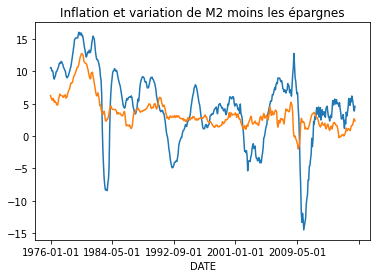

In [3]:
plt.figure()
delta_difference['M2_less_savings'].plot()
inflation['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

<Figure size 432x288 with 0 Axes>

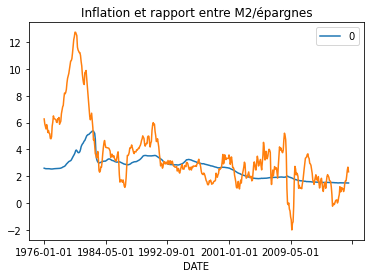

In [4]:
plt.figure()
rapport.plot()
inflation['delta'].plot()
plt.title('Inflation et rapport entre M2/épargnes')
plt.show()

In [5]:
############# Analyse statistique de base #############

## inlfation et delta différence entre 1976 et 2017 ##

x1 = inflation['delta'].values
y1 = delta_difference['M2_less_savings'].values

coeff_pearson = pearsonr(x1,y1)
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = (0.6141310647672451, 1.2020602172269806e-52)


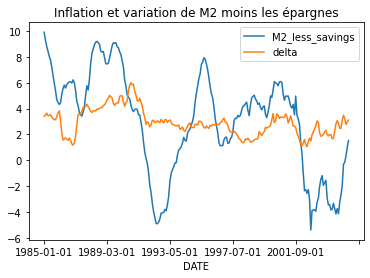

In [6]:
## inlfation et delta différence entre 1985 et 2005 ##

delta_difference_1985 = delta_difference.loc['1985-01-01':'2005-03-01']
inflation_1985 = inflation.loc['1985-01-01':'2005-03-01']

plt.figure()
delta_difference_1985['M2_less_savings'].plot(legend='M2 moins épargnes')
inflation_1985['delta'].plot(legend='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [7]:
############# Analyse statistique de base #############

x2 = inflation_1985['delta'].values
y2 = delta_difference_1985['M2_less_savings'].values

coeff_pearson = pearsonr(x2,y2)
print("coefficient de Pearson entre 1985 et 2005 = {}".format(coeff_pearson))

# Entre 1983 et 2001 on obtient : coefficient de Pearson = (0.2661862613252829, 6.639230681995491e-05)

coefficient de Pearson entre 1985 et 2005 = (0.3744243609646771, 1.667439706937323e-09)


In [30]:
######### Analyse stat avec dcorr (distance correlation) #########

x3 = inflation_1985['delta'].values
y3 = delta_difference_1985['M2_less_savings'].values

correlation = dcorr(x3,y3)

print(correlation)

0.7332007503760888


# Étude Tau linéaire

In [31]:
def T(a,b,x):
    return a*x+b

## Étude de tau sur les séries standardisées

In [32]:
## Je vais utiliser les dataframe de 1981 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1983-01-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1983-01-01':'2007-03-01']

scaler = StandardScaler()

In [33]:
### Construction du T idéal ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.005*i for i in range(0,31)]

for a in A:

    for b in range(0,25):
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.34 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard


print(Solution_ideale_standard)
print(Meilleurs_solutions_standard)

<ipython-input-33-ed1af1443f4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[0.135, 0, (0.35576585391127946, 6.202652804269837e-08)]
[[0.1, 0, (0.3428355791085212, 1.9608225988834026e-07)], [0.105, 0, (0.34885233613598954, 1.1551344785917944e-07)], [0.105, 1, (0.343212283041821, 1.8975425495900317e-07)], [0.11, 0, (0.35218289367149463, 8.577116329952148e-08)], [0.11, 1, (0.343921514415477, 1.7836832113913263e-07)], [0.115, 0, (0.35352977408735076, 7.596800461718812e-08)], [0.115, 1, (0.3427523604141844, 1.9750726174695062e-07)], [0.12, 0, (0.35322306319747016, 7.810081143600786e-08)], [0.12, 1, (0.3432842668081929, 1.8856756434353147e-07)

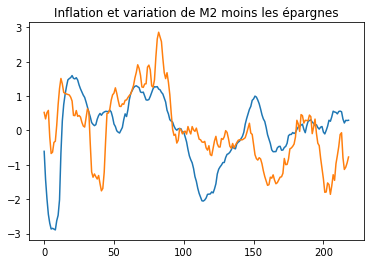

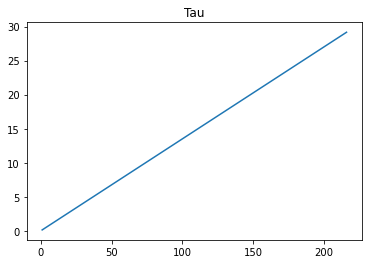

In [34]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0.135,0,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()

# Étude de tau sur les séries non standardisées

In [12]:
delta_difference_1983_2001 = delta_difference.loc['1983-01-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1983-01-01':'2007-03-01']

In [13]:
### Construction du T idéal ###

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_values = delta_difference_1983_2001['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_values = delta_difference_1983_2001_values.reshape((len(values), 1))
delta_difference_1983_2001_values = delta_difference_1983_2001_values.tolist()

for j in range(len(delta_difference_1983_2001_values)):     
            delta_difference_1983_2001_values[j] = delta_difference_1983_2001_values[j][0]  # Mise au bon format

Meilleurs_solutions = []
R_best = 0
Solution_ideale = [0,0,0]
inflation_shift_ideale = [0 for x in range(len(delta_difference_1983_2001_values))]

A = [0.005*i for i in range(0,31)]

for a in A:
    for b in range(0,37):
        infla = [0 for x in range(len(delta_difference_1983_2001_values))]
        for i in range(len(delta_difference_1983_2001_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        infla = np.array(infla)
        infla = infla.reshape((len(values), 1))
        infla = infla.tolist()

        for j in range(len(infla)):     # Mise au bon format
            infla[j] = infla[j][0]

        R = pearsonr(infla,delta_difference_1983_2001_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions.append([a,b,R])

        if abs(R[0]) > abs(R_best):
            Solution_ideale = [a,b,R]
            R_best = R[0]
            inflation_shift_ideale = infla


print(Solution_ideale)
print(R_best)
print(Meilleurs_solutions)

[0.15, 36, (0.4880198168650733, 1.6620949303702808e-14)]
0.4880198168650733
[[0.105, 36, (0.41021195452316744, 2.683884070070347e-10)], [0.11, 36, (0.4220587415266059, 7.162352221333788e-11)], [0.115, 35, (0.40221078368742713, 6.364031036868931e-10)], [0.115, 36, (0.4327930970902346, 2.0681048202860676e-11)], [0.12, 35, (0.41218846380179336, 2.1607142579726798e-10)], [0.12, 36, (0.4406376323223266, 8.112602103292363e-12)], [0.125, 35, (0.4212316607398634, 7.86755138448194e-11)], [0.125, 36, (0.44976596786374734, 2.648162896405955e-12)], [0.13, 35, (0.43032816678517216, 2.7614570714891446e-11)], [0.13, 36, (0.45979058237760695, 7.448347627426081e-13)], [0.135, 34, (0.4051293076610467, 4.657018975778979e-10)], [0.135, 35, (0.4404160413721494, 8.33266629960855e-12)], [0.135, 36, (0.46964441540993784, 2.054751848225634e-13)], [0.14, 34, (0.4166455271080307, 1.318204543948481e-10)], [0.14, 35, (0.4511898588019645, 2.2171182687066043e-12)], [0.14, 36, (0.4749276923960437, 1.0125522396495859e

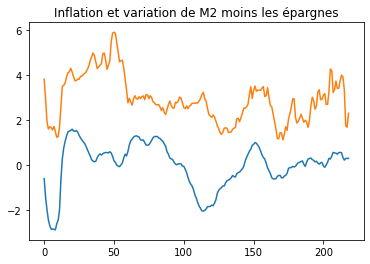

In [14]:
plt.figure()
plt.plot(delta_difference_1983_2001_values,label='M')
plt.plot(inflation_shift_ideale,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

# Étude avec Tau log

## Étude de tau sur les séries standardisées

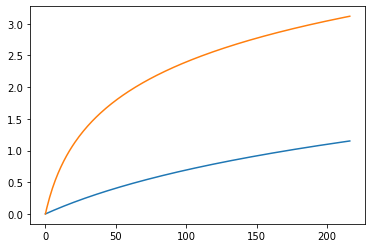

In [15]:
plt.figure()
X = [x for x in range(0,217)]
Y=[]
for x in X:
    Y.append(m.log(0.01*x+1))
plt.plot(X,Y)
Y=[]
for x in X:
    Y.append(m.log(0.1*x+1))
plt.plot(X,Y)
plt.show()

### a va de 0.001 à 0.1 par pas de 0.001 soit 100 valeurs

In [16]:
print(m.exp(3))   ### b va de 1 à 20
print(m.log(1.17)*12)

20.085536923187668
1.8840449857159762


In [35]:
def T(a,b,x):
    return(12*(m.log(a*x+b)))

In [36]:
###### Standardization de la série temporelle ######

## Je vais utiliser les dataframe de 1981 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1983-01-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1983-01-01':'2007-03-01']

scaler = StandardScaler()

In [37]:
### Construction du T idéal ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.001*i for i in range(1,101)]
B = [0.5*i for i in range(2,41)]

for a in A:

    for b in B:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard


print(Solution_ideale_standard)
print(R_best_standard)
print(Meilleurs_solutions_standard)

<ipython-input-37-ddf02faa024d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[0.017, 1.0, (0.3485730794280876, 1.1841465567752184e-07)]
0.3485730794280876
[]


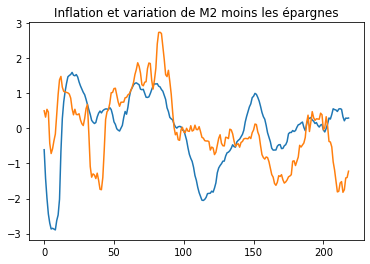

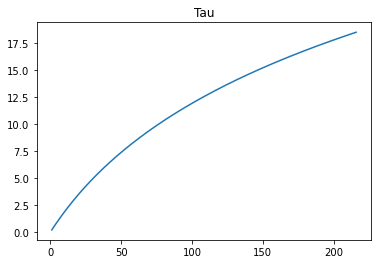

In [38]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0.017,1,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()